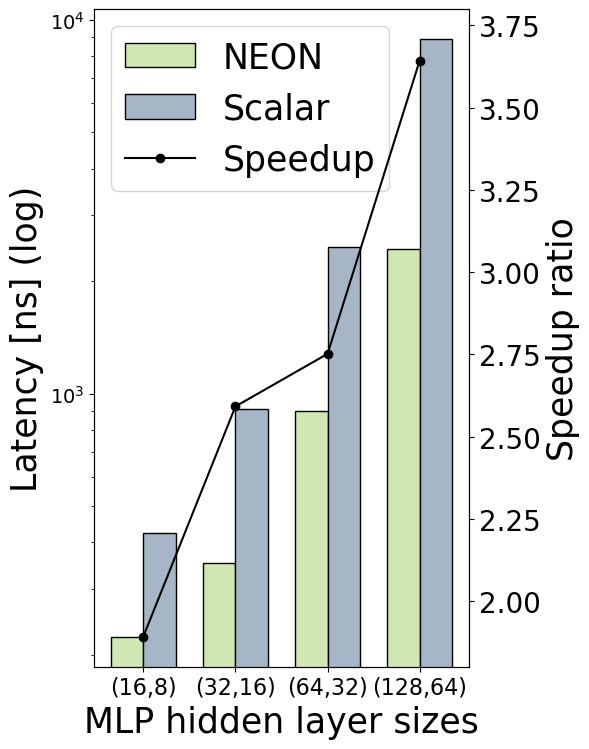

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- user-editable -----------------
dir_neon   = "/home/ubuntu/DoH_DGA_training/notebooks/lat_neon"
dir_scalar = "/home/ubuntu/DoH_DGA_training/notebooks/lat_scalar"
models = ['16', '32', '64', '128']   # subfolders to read
tsc_hz = 300254821                   # TSC frequency (Hz) for cycles -> ns conversion
take_head = 1000                      # like your template: consider only first N rows
# -------------------------------------------------

# Mapping model folder -> label for hidden layers
model_label_map = {
    '16': '(16,8)',
    '32': '(32,16)',
    '64': '(64,32)',
    '128': '(128,64)',
}

def read_timings_file(base_dir, model):
    """Return path to timings_core0.csv inside model subfolder (or None)."""
    fp = os.path.join(base_dir, model, "timings_core0.csv")
    return fp if os.path.exists(fp) else None

def compute_mean_inference_ns(fp):
    """Read timings CSV and compute mean((feat_cycles + inf_cycles) -> ns) over first `take_head` rows."""
    df = pd.read_csv(fp).head(take_head)
    if 'feat_cycles' in df.columns and 'inf_cycles' in df.columns:
        cycles_sum = df['feat_cycles'].astype(float) + df['inf_cycles'].astype(float)
        cycles_sum = cycles_sum.replace([np.inf, -np.inf], np.nan).dropna()
        if cycles_sum.size == 0:
            return np.nan
        ns = (cycles_sum / float(tsc_hz)) * 1e9
        return float(ns.mean())
    if 'inf_cycles' in df.columns:
        cycles_sum = df['inf_cycles'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if cycles_sum.size == 0:
            return np.nan
        ns = (cycles_sum / float(tsc_hz)) * 1e9
        return float(ns.mean())
    for c in ['inf_ns', 'inference_ns', 'latency_ns', 'ns']:
        if c in df.columns:
            arr = df[c].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
            return float(arr.mean()) if arr.size > 0 else np.nan
    if 'cycles' in df.columns:
        cycles = df['cycles'].astype(float).replace([np.inf, -np.inf], np.nan).dropna()
        if cycles.size == 0:
            return np.nan
        ns = (cycles / float(tsc_hz)) * 1e9
        return float(ns.mean())
    return np.nan

# Collect means
labels = []
lat_neon_ns = []
lat_scalar_ns = []

for m in models:
    f_neon = read_timings_file(dir_neon, m)
    f_scalar = read_timings_file(dir_scalar, m)

    if f_neon is None or f_scalar is None:
        print(f"[WARN] Missing timings for model {m}")
        continue

    neon_mean = compute_mean_inference_ns(f_neon)
    scalar_mean = compute_mean_inference_ns(f_scalar)

    if np.isnan(neon_mean) or np.isnan(scalar_mean):
        print(f"[WARN] Skipping {m}: insufficient data")
        continue

    labels.append(m)
    lat_neon_ns.append(neon_mean)
    lat_scalar_ns.append(scalar_mean)

if not labels:
    raise SystemExit("No valid models read. Check folder layout and filenames.")

# compute speedup = SCALAR / NEON (since scalar is slower)
speedup = [s / n if n != 0 else np.nan for n, s in zip(lat_neon_ns, lat_scalar_ns)]

# ─── Plot (template styling) ───────────────────────────────────────────────────
colors = ['#d0e7b3', '#a7b6c6']  # [NEON-green, Scalar-blue]
x     = range(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(6, 7.6))

# NEON bars on the left, Scalar on the right
ax1.bar([i - width/2 for i in x], lat_neon_ns, width=width,
        label="NEON", color=colors[0], edgecolor="black", linewidth=1)
ax1.bar([i + width/2 for i in x], lat_scalar_ns, width=width,
        label="Scalar", color=colors[1], edgecolor="black", linewidth=1)

ax1.set_yscale('log')
ax1.set_xlabel("MLP hidden layer sizes", fontsize=25)
ax1.set_ylabel("Latency [ns] (log)", fontsize=25)
ax1.set_xticks(list(x))
ax1.set_xticklabels([model_label_map.get(l, l) for l in labels], fontsize=16)
ax1.tick_params(axis="y", labelsize=14)

# secondary axis for speedup
ax2 = ax1.twinx()
ax2.plot(x, speedup, marker="o", linestyle="-", color="black", label="Speedup")
ax2.set_ylabel("Speedup ratio", fontsize=25)
ax2.tick_params(axis="y", labelsize=20)
ax2.set_ylim(1.8, 3.8)

# custom label offsets
#offsets = [(-29, 5), (0, 5), (30, -25), (-35, -10)]
#for (xi, sp), ofs in zip(zip(x, speedup), offsets):
#    ax2.annotate(f"{sp:.2f}×",
#                 xy=(xi, sp), xytext=ofs,
#                 textcoords="offset points",
#                 ha="center", va="bottom", fontsize=20)

# combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=25, ncol=1)
plt.savefig("mlp_neon_scalar_inference_lat.pdf", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()


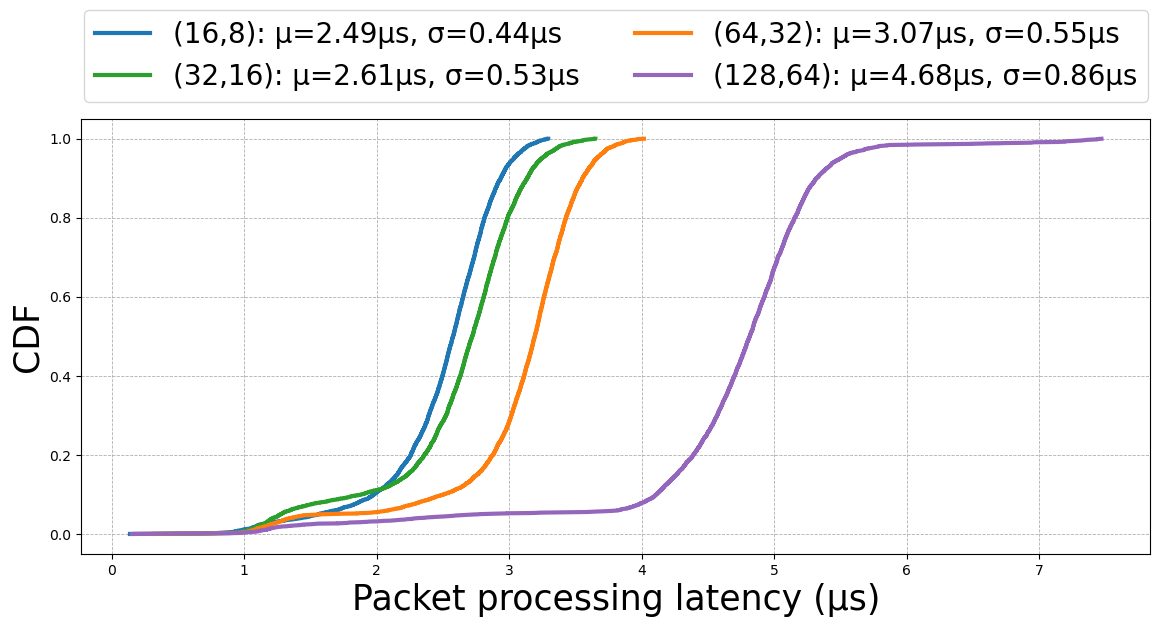


Summary (after removing >99th percentile):
  Model (16,8): mean = 2.4939 µs, std = 0.4375 µs
  Model (32,16): mean = 2.6099 µs, std = 0.5305 µs
  Model (64,32): mean = 3.0709 µs, std = 0.5511 µs
  Model (128,64): mean = 4.6805 µs, std = 0.8564 µs


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- user-editable ---
data_dir = "/home/ubuntu/DoH_DGA_training/notebooks/lat_neon"   # path containing subfolders 16,32,64,128
models = ['16', '32', '64', '128']
tsc_hz = 300254821   # TSC frequency (Hz)
percentile_cut = 99  # remove values above this percentile (set to 99 to remove top 1%)
# ----------------------

colors = {
    '16': '#1f77b4',
    '32': '#2ca02c',
    '64': '#ff7f0e',
    '128': '#9467bd',
}

model_label_map = {
    '16': '(16,8)',
    '32': '(32,16)',
    '64': '(64,32)',
    '128': '(128,64)'
}

fig, ax = plt.subplots(figsize=(12,6.2))
plt.rcParams.update({'font.size': 20})  # set font size to 20

summary_stats = {}

def read_latencies(folder):
    fp = os.path.join(folder, "latencies_core0.csv")
    if not os.path.exists(fp):
        print(f"[WARN] Missing latencies file: {fp}")
        return None
    return pd.read_csv(fp)

def cycles_to_us(cycles, tsc_hz):
    # cycles * (1e6 / tsc_hz) gives microseconds
    return np.asarray(cycles, dtype=float) * (1e6 / float(tsc_hz))

for model in models:
    folder = os.path.join(data_dir, model)
    lat_df = read_latencies(folder)
    if lat_df is None or lat_df.empty:
        print(f"[INFO] Skipping model {model} (no latencies file).")
        continue

    # ensure required columns exist
    if not {'sample', 'cycles', 'ns'}.issubset(lat_df.columns):
        print(f"[WARN] latencies_core0.csv in {folder} missing required columns. Skipping.")
        continue

    # Convert cycles -> microseconds using tsc_hz
    packet_us_from_cycles = cycles_to_us(lat_df['cycles'].values, tsc_hz)

    # remove NaNs/Infs
    packet_us = pd.Series(packet_us_from_cycles).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
    if packet_us.size == 0:
        print(f"[INFO] No valid packets for model {model}.")
        continue

    # remove top (100 - percentile_cut)% outliers (e.g. percentile_cut=95 removes top 5%)
    p_val = np.percentile(packet_us, percentile_cut)
    filtered = packet_us[packet_us <= p_val]
    if filtered.size == 0:
        print(f"[WARN] No data left after removing >{percentile_cut}th percentile for model {model}. Skipping.")
        continue

    # compute mean/std on filtered data
    mu = filtered.mean()
    sigma = filtered.std(ddof=0)
    summary_stats[model] = (mu, sigma)

    # Compute CDF using filtered values
    sorted_vals = np.sort(filtered)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    label = f"{model_label_map.get(model, model)}: µ={mu:.2f}µs, σ={sigma:.2f}µs"
    ax.plot(sorted_vals, cdf, label=label, color=colors.get(model), linewidth=3)

# Build legend and place it above the plot (like a title) with one entry per line
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.53, 1.05),  # slightly above the top of the axes
           ncol=2,                      # stacked vertically
           fontsize=20,
           frameon=True)

# Formatting
ax.set_xlabel("Packet processing latency (µs)", fontsize=25)
ax.set_ylabel("CDF", fontsize=25)
ax.grid(True, which='both', linestyle='--', linewidth=0.6)

# leave room at the top for the legend
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig("mlp_neon_pkt_lat.pdf", bbox_inches="tight", dpi=300)
plt.show()

print(f"\nSummary (after removing >{percentile_cut}th percentile):")
for m, (mu, sigma) in summary_stats.items():
    print(f"  Model {model_label_map.get(m, m)}: mean = {mu:.4f} µs, std = {sigma:.4f} µs")


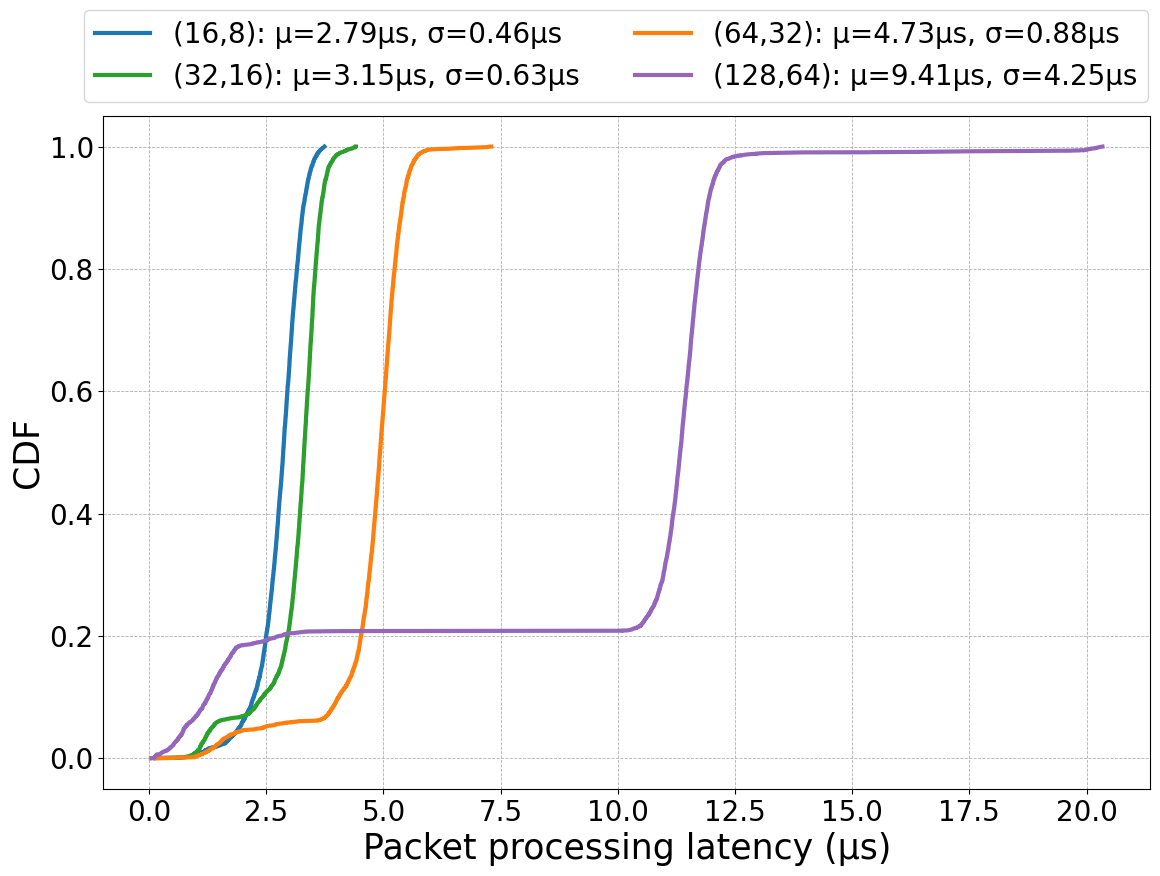


Summary (after removing >99th percentile):
  Model (16,8): mean = 2.7937 µs, std = 0.4633 µs
  Model (32,16): mean = 3.1506 µs, std = 0.6315 µs
  Model (64,32): mean = 4.7326 µs, std = 0.8803 µs
  Model (128,64): mean = 9.4129 µs, std = 4.2544 µs


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- user-editable ---
data_dir = "/home/ubuntu/DoH_DGA_training/notebooks/lat_scalar"   # path containing subfolders 16,32,64,128
models = ['16', '32', '64', '128']
tsc_hz = 300254821   # TSC frequency (Hz)
percentile_cut = 99  # remove values above this percentile (set to 99 to remove top 1%)
# ----------------------

colors = {
    '16': '#1f77b4',
    '32': '#2ca02c',
    '64': '#ff7f0e',
    '128': '#9467bd',
}

model_label_map = {
    '16': '(16,8)',
    '32': '(32,16)',
    '64': '(64,32)',
    '128': '(128,64)'
}

fig, ax = plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})  # set font size to 20

summary_stats = {}

def read_latencies(folder):
    fp = os.path.join(folder, "latencies_core0.csv")
    if not os.path.exists(fp):
        print(f"[WARN] Missing latencies file: {fp}")
        return None
    return pd.read_csv(fp)

def cycles_to_us(cycles, tsc_hz):
    # cycles * (1e6 / tsc_hz) gives microseconds
    return np.asarray(cycles, dtype=float) * (1e6 / float(tsc_hz))

for model in models:
    folder = os.path.join(data_dir, model)
    lat_df = read_latencies(folder)
    if lat_df is None or lat_df.empty:
        print(f"[INFO] Skipping model {model} (no latencies file).")
        continue

    # ensure required columns exist
    if not {'sample', 'cycles', 'ns'}.issubset(lat_df.columns):
        print(f"[WARN] latencies_core0.csv in {folder} missing required columns. Skipping.")
        continue

    # Convert cycles -> microseconds using tsc_hz
    packet_us_from_cycles = cycles_to_us(lat_df['cycles'].values, tsc_hz)

    # remove NaNs/Infs
    packet_us = pd.Series(packet_us_from_cycles).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
    if packet_us.size == 0:
        print(f"[INFO] No valid packets for model {model}.")
        continue

    # remove top (100 - percentile_cut)% outliers (e.g. percentile_cut=95 removes top 5%)
    p_val = np.percentile(packet_us, percentile_cut)
    filtered = packet_us[packet_us <= p_val]
    if filtered.size == 0:
        print(f"[WARN] No data left after removing >{percentile_cut}th percentile for model {model}. Skipping.")
        continue

    # compute mean/std on filtered data
    mu = filtered.mean()
    sigma = filtered.std(ddof=0)
    summary_stats[model] = (mu, sigma)

    # Compute CDF using filtered values
    sorted_vals = np.sort(filtered)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)

    label = f"{model_label_map.get(model, model)}: µ={mu:.2f}µs, σ={sigma:.2f}µs"
    ax.plot(sorted_vals, cdf, label=label, color=colors.get(model), linewidth=3)

# Build legend and place it above the plot (like a title) with one entry per line
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.53, 1),  # slightly above the top of the axes
           ncol=2,                      # stacked vertically
           fontsize=20,
           frameon=True)

# Formatting
ax.set_xlabel("Packet processing latency (µs)", fontsize=25)
ax.set_ylabel("CDF", fontsize=25)
ax.grid(True, which='both', linestyle='--', linewidth=0.6)

# leave room at the top for the legend
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig("mlp_scalar_pkt_lat.pdf", bbox_inches="tight", dpi=300)
plt.show()

print(f"\nSummary (after removing >{percentile_cut}th percentile):")
for m, (mu, sigma) in summary_stats.items():
    print(f"  Model {model_label_map.get(m, m)}: mean = {mu:.4f} µs, std = {sigma:.4f} µs")


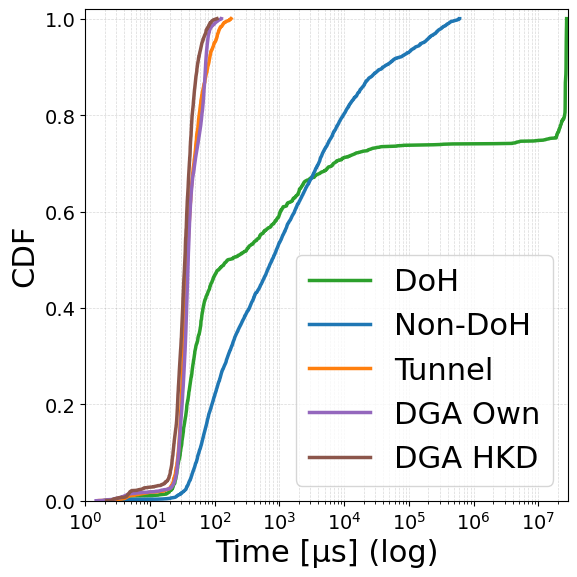


Summary (values trimmed at >99th percentile):
  DoH        | mean = 6450538.393 µs | std = 11090411.789 µs | samples = 1774
  Non-DoH    | mean = 23010.124 µs | std = 73807.901 µs | samples = 4950
  Tunnel     | mean = 45.778 µs | std = 24.548 µs | samples = 1906
  DGA Own    | mean = 44.723 µs | std = 18.348 µs | samples = 4600
  DGA HKD    | mean = 36.578 µs | std = 14.260 µs | samples = 2067

Saved plot to: flow_duration_cdf_99pct.pdf


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- user-editable ---
data_dir = "/home/ubuntu/DoH_DGA_training/notebooks/lat_flow"   # main folder containing the csv files
files = [  
    "doh.csv",                             
    "non_doh.csv",
    "tunnel.csv",
    "dga_own.csv",
    "dga_hkd.csv"
]
percentile_cut = 99   # remove values above this percentile (set to 99 to remove top 1%)
# ----------------------

# Optional: map filename (without .csv) to nicer plotting labels
label_map = {
    "non_doh": "Non-DoH",
    "doh": "DoH",
    "tunnel": "Tunnel",
    "dga_own": "DGA Own",
    "dga_hkd": "DGA HKD",
}

# Colors for plotting (add more if needed)
colors = {
    "non_doh": "#1f77b4",
    "doh": "#2ca02c",
    "tunnel": "#ff7f0e",
    "dga_own": "#9467bd",
    "dga_hkd": "#8c564b",
}

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6,6))

summary_stats = {}

def read_csv_fp(fp):
    if not os.path.exists(fp):
        print(f"[WARN] Missing file: {fp}")
        return None
    try:
        return pd.read_csv(fp)
    except Exception as e:
        print(f"[WARN] Failed reading {fp}: {e}")
        return None

for fname in files:
    fp = os.path.join(data_dir, fname)
    df = read_csv_fp(fp)
    if df is None or df.empty:
        print(f"[INFO] Skipping {fname} (missing or empty).")
        continue

    # use filename without extension as key
    key = os.path.splitext(os.path.basename(fname))[0]

    # check expected column
    if 'flow_duration_ns' not in df.columns:
        print(f"[WARN] {fname} does not contain 'flow_duration_ns' column. Skipping.")
        continue

    # convert to numeric ns values and drop invalids
    vals_ns = pd.to_numeric(df['flow_duration_ns'], errors='coerce').dropna().to_numpy()
    if vals_ns.size == 0:
        print(f"[INFO] No valid flow_duration_ns values in {fname}.")
        continue

    # trim above percentile_cut
    cutoff = np.percentile(vals_ns, percentile_cut)
    filtered = vals_ns[vals_ns <= cutoff]
    if filtered.size == 0:
        print(f"[WARN] No data left after trimming >{percentile_cut}th percentile for {fname}. Skipping.")
        continue

    # compute summary stats (we'll report microseconds for readability)
    mean_ns = filtered.mean()
    std_ns = filtered.std(ddof=0)
    mean_us = mean_ns / 1000.0
    std_us = std_ns / 1000.0
    summary_stats[key] = (mean_us, std_us, filtered.size)

    # compute CDF (x axis in milliseconds or microseconds — choose µs here)
    sorted_vals_us = np.sort(filtered / 1000.0)  # convert ns -> µs
    cdf = np.arange(1, len(sorted_vals_us) + 1) / len(sorted_vals_us)

    label = label_map.get(key, key)
    clr = colors.get(key, None)
    ax.plot(sorted_vals_us, cdf, label=f"{label}", color=clr, linewidth=2.5)

# Formatting
ax.set_xlabel("Time [µs] (log)", fontsize=22)
ax.set_ylabel("CDF", fontsize=22)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
ax.set_xlim(left=0)
ax.set_ylim(0, 1.02)
ax.set_xscale('log')
ax.set_xlim(left=1)  # or set to the minimum meaningful value, e.g., 1 µs
# Legend
ax.legend(loc='lower right', fontsize=22, frameon=True)

plt.tight_layout()
out_pdf = "flow_duration_cdf_99pct.pdf"
plt.savefig(out_pdf, bbox_inches="tight", dpi=300)
plt.show()

# Print summary stats
print(f"\nSummary (values trimmed at >{percentile_cut}th percentile):")
for k, (mu_us, sigma_us, count) in summary_stats.items():
    label = label_map.get(k, k)
    print(f"  {label:<10} | mean = {mu_us:.3f} µs | std = {sigma_us:.3f} µs | samples = {count}")
print(f"\nSaved plot to: {out_pdf}")


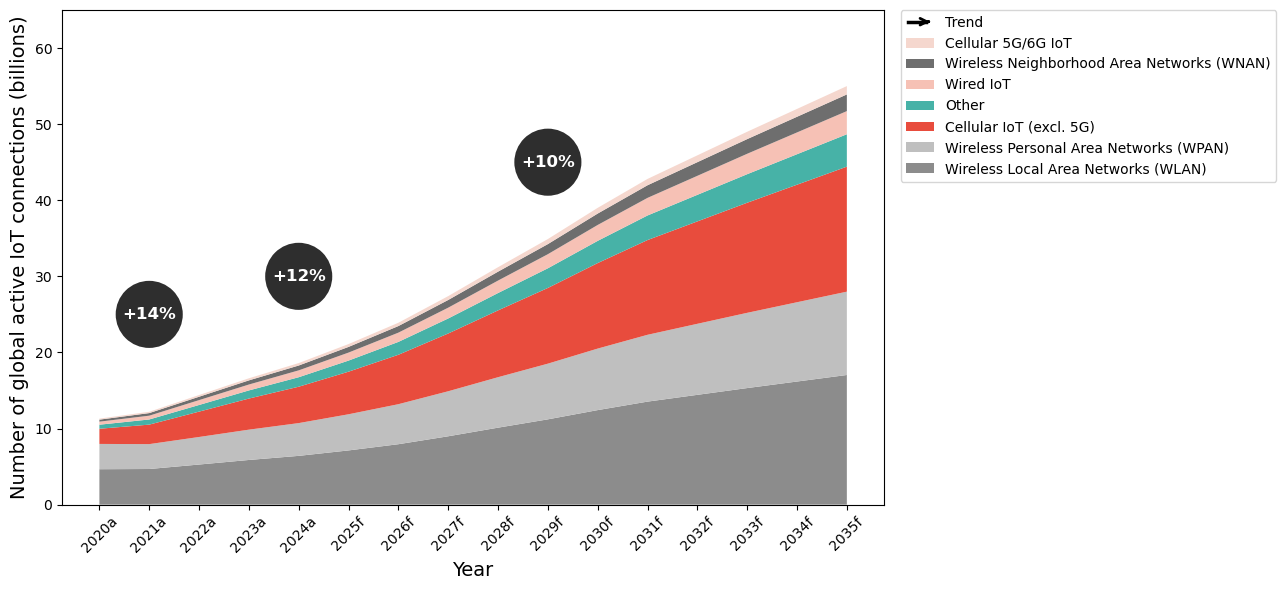

Saved to: iot_stacked_area_legend_trend_arrow.png


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from pathlib import Path

# --- data (same as yours) ---
years = np.arange(2020, 2036)
year_labels = [f"{y}a" if y <= 2024 else f"{y}f" for y in years]
total = np.array([11.3, 12.2, 14.4, 16.6, 18.6, 21.1, 23.9, 27.4, 31.2, 34.9,
                  39.0, 42.8, 45.9, 49.0, 52.0, 55.0])

p_wlan = np.linspace(3.5, 14.0, len(years))
p_wpan = np.linspace(2.5, 9.0, len(years))
p_cellular_ex = np.linspace(1.5, 13.5, len(years))
p_other = np.linspace(0.4, 3.5, len(years))
p_wired = np.linspace(0.3, 2.5, len(years))
p_wnan = np.linspace(0.2, 1.8, len(years))
p_cellular_5g = np.linspace(0.1, 0.9, len(years))

components = np.vstack([
    p_wlan, p_wpan, p_cellular_ex, p_other, p_wired, p_wnan, p_cellular_5g
])
scale = total / components.sum(axis=0)
components_scaled = (components * scale).T

# --- labels/colors ---
plot_labels = [
    "Wireless Local Area Networks (WLAN)",
    "Wireless Personal Area Networks (WPAN)",
    "Cellular IoT (excl. 5G)",
    "Other",
    "Wired IoT",
    "Wireless Neighborhood Area Networks (WNAN)",
    "Cellular 5G/6G IoT"
]
colors = [
    "#8C8C8C", "#BFBFBF", "#E84C3D", "#47B2A7",
    "#F6C1B5", "#6E6E6E", "#F5D7CE"
]

# --- custom legend handler that draws a short line + arrowhead ---
class HandlerArrowLine(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # coordinates inside legend box (0..1 box normalized)
        # build a short line from left to ~80% of width and an arrow from 80%->right
        y = 0.5 * height + ydescent
        x0 = xdescent + 0.05 * width
        xm = xdescent + 0.70 * width
        x1 = xdescent + 0.95 * width

        # line segment
        line = Line2D([x0, xm], [y, y], transform=trans, color='black', linewidth=2.5)
        # small arrow patch at end
        arrow = FancyArrowPatch((xm, y), (x1, y),
                                transform=trans,
                                arrowstyle='->', mutation_scale=12,
                                linewidth=2, color='black')
        return [line, arrow]

# --- plotting ---
plt.figure(figsize=(13, 6))
plt.stackplot(years, components_scaled.T, labels=plot_labels, colors=colors)

# annotations (only the circular percentage markers)
growth_labels = ["+14%", "+12%", "+10%"]
growth_positions = [2021, 2024, 2029]
growth_heights = [25, 30, 45]
for label, x, y in zip(growth_labels, growth_positions, growth_heights):
    plt.text(x, y, label, fontsize=12, fontweight='bold',
             color='white', ha='center', va='center',
             bbox=dict(boxstyle="circle,pad=0.4", fc="#2E2E2E", ec="none"))

# reverse legend order for stacked items
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = handles[::-1], labels[::-1]

# create a proxy handle for the "Trend" entry (type can be anything; we map it to custom handler)
trend_proxy = Line2D([], [])  # empty Line2D works as a proxy

# build final legend: first the trend proxy, then the stacked-area handles (reversed)
all_handles = [trend_proxy] + handles
all_labels = ["Trend"] + labels

# draw legend using our custom handler for the proxy (map its type to HandlerArrowLine)
plt.legend(all_handles, all_labels,
           handler_map={type(trend_proxy): HandlerArrowLine()},
           loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

# axis formatting
plt.xticks(years, year_labels, rotation=45)
plt.ylim(0, 65)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of global active IoT connections (billions)", fontsize=14)
plt.tight_layout()

# save
out_path = Path("iot_stacked_area_legend_trend_arrow.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved to:", out_path)
